In [1]:
import sys
import logging

import numpy as np
from scipy.stats import skew
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from IPython.display import display

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# Regression walkthrough

Based on: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

"An attempt to use every trick in the books to unleash the full power of Linear Regression, pre-processing and several regularisation algorithms"



In [2]:
train = pd.read_csv("../data/raw/train.csv")
train.shape

(1460, 81)

In [3]:
# Duplicates check
ids_unique = len(set(train.Id))
ids_total = train.shape[0]
duplicate_id_count = ids_total - ids_unique

print(f"There are {duplicate_id_count} duplicate IDs out of {ids_total} entries")

There are 0 duplicate IDs out of 1460 entries


In [6]:
train.loc[train["GarageYrBlt"].isnull(), "GarageYrBlt"] = train.loc[train["GarageYrBlt"].isnull(), "YearBuilt"]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## Pre-processing



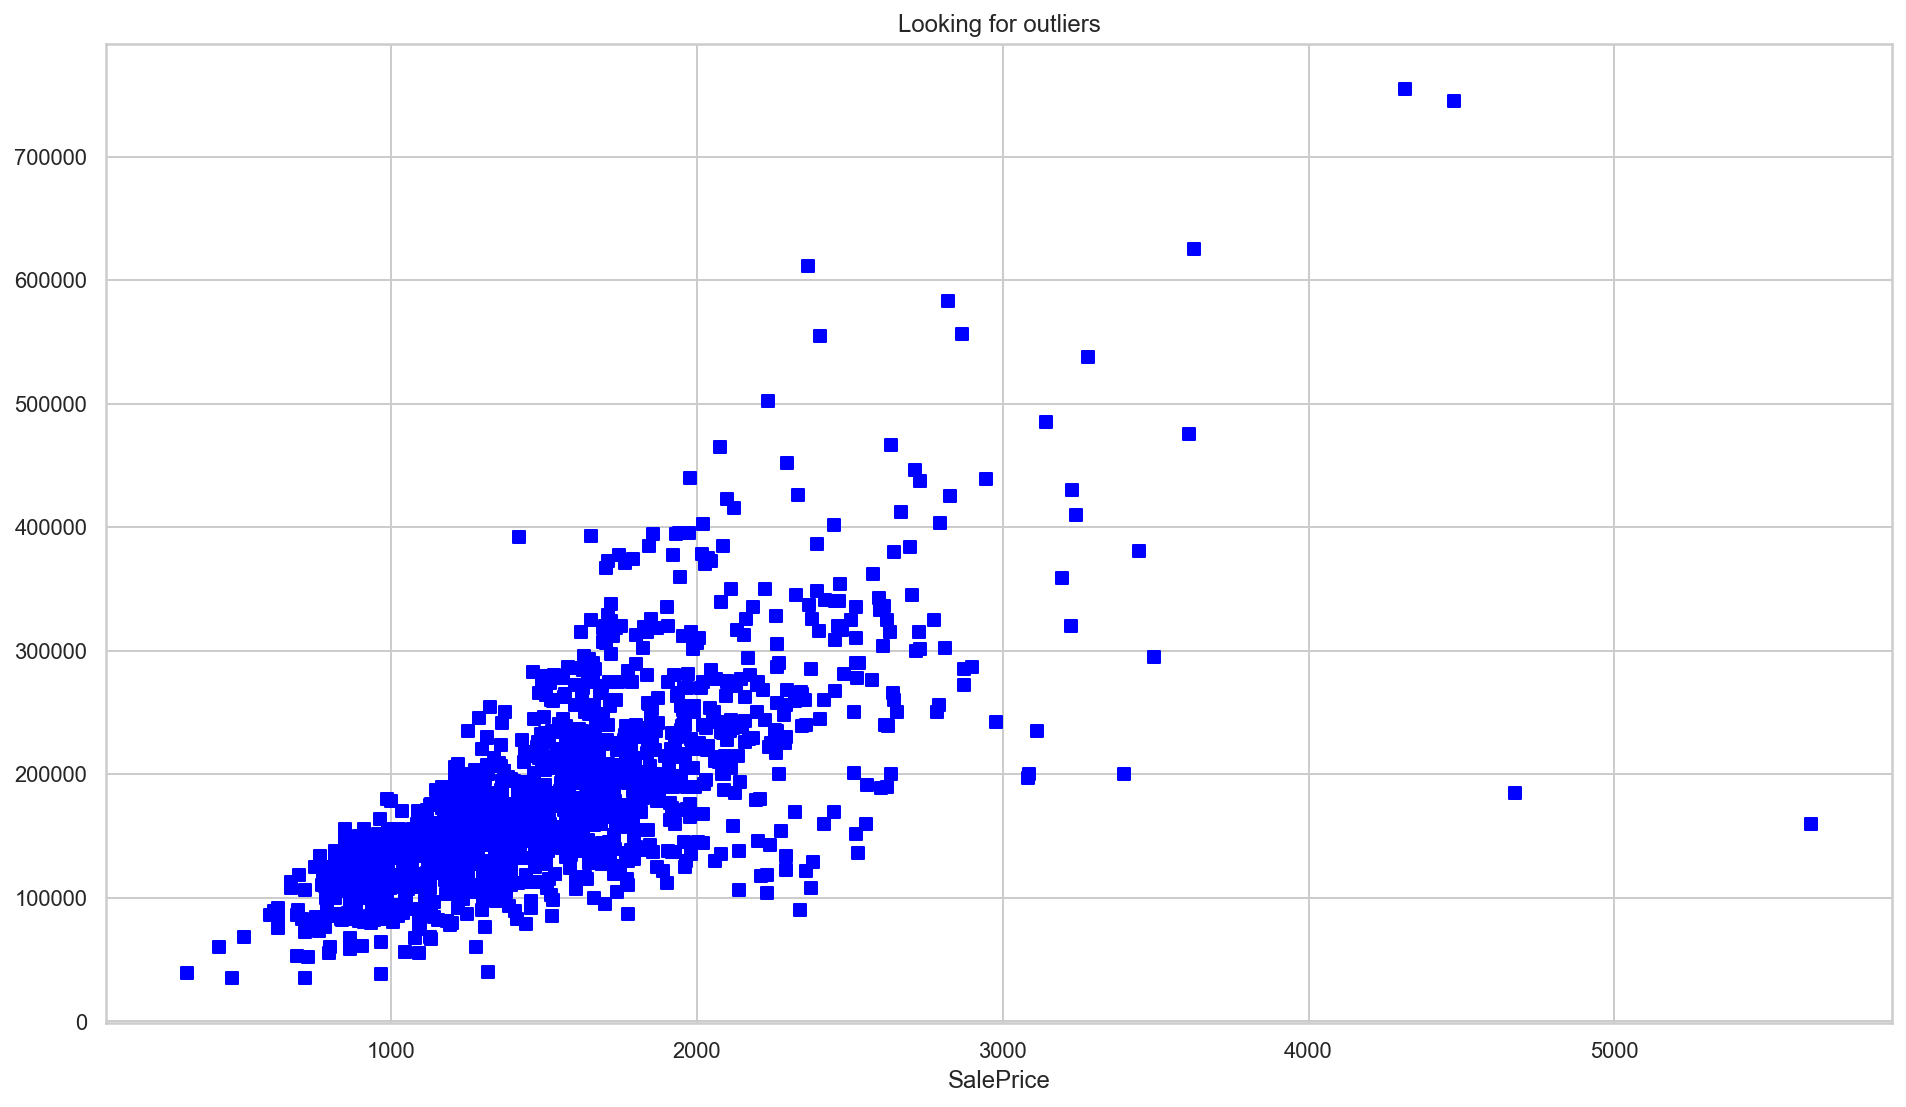

In [4]:
plt.scatter(train.GrLivArea, train.SalePrice, c="blue", marker="s")
plt.title("Looking for outliers")
plt.xlabel("GrLivArea")
plt.xlabel("SalePrice")
plt.show()

Drop the houses with more than 4000 sq feet following dataset author recommendations:
https://ww2.amstat.org/publications/jse/v19n3/decock.pdf

### Pre-processing steps added

* Filter large house outliers
* Log transform the target (Sale Price)
    * errors have same effect whether the house is cheap or not


In [12]:
def start_pipeline(df):
    """
    Start pipeline with a copy to avoid SettingWithCopyWarning
    """
    return df.copy()


def drop_id_column(df):
    return df.drop("Id", axis=1)


def filter_large_house_outliers(df):
    """
    Drop the houses with more than 4000 sq feet following 
    dataset author recommendations.
    """
    return df[df.GrLivArea < 4000]


def log_transform_sale_price(df):
    df.SalePrice = np.log1p(df.SalePrice)
    return df


def preprocessing_pipeline(df):
    return (df
            .pipe(start_pipeline)
            .pipe(drop_id_column)
            .pipe(filter_large_house_outliers)
            .pipe(log_transform_sale_price))

In [15]:
train = preprocessing_pipeline(train)
y = train.SalePrice

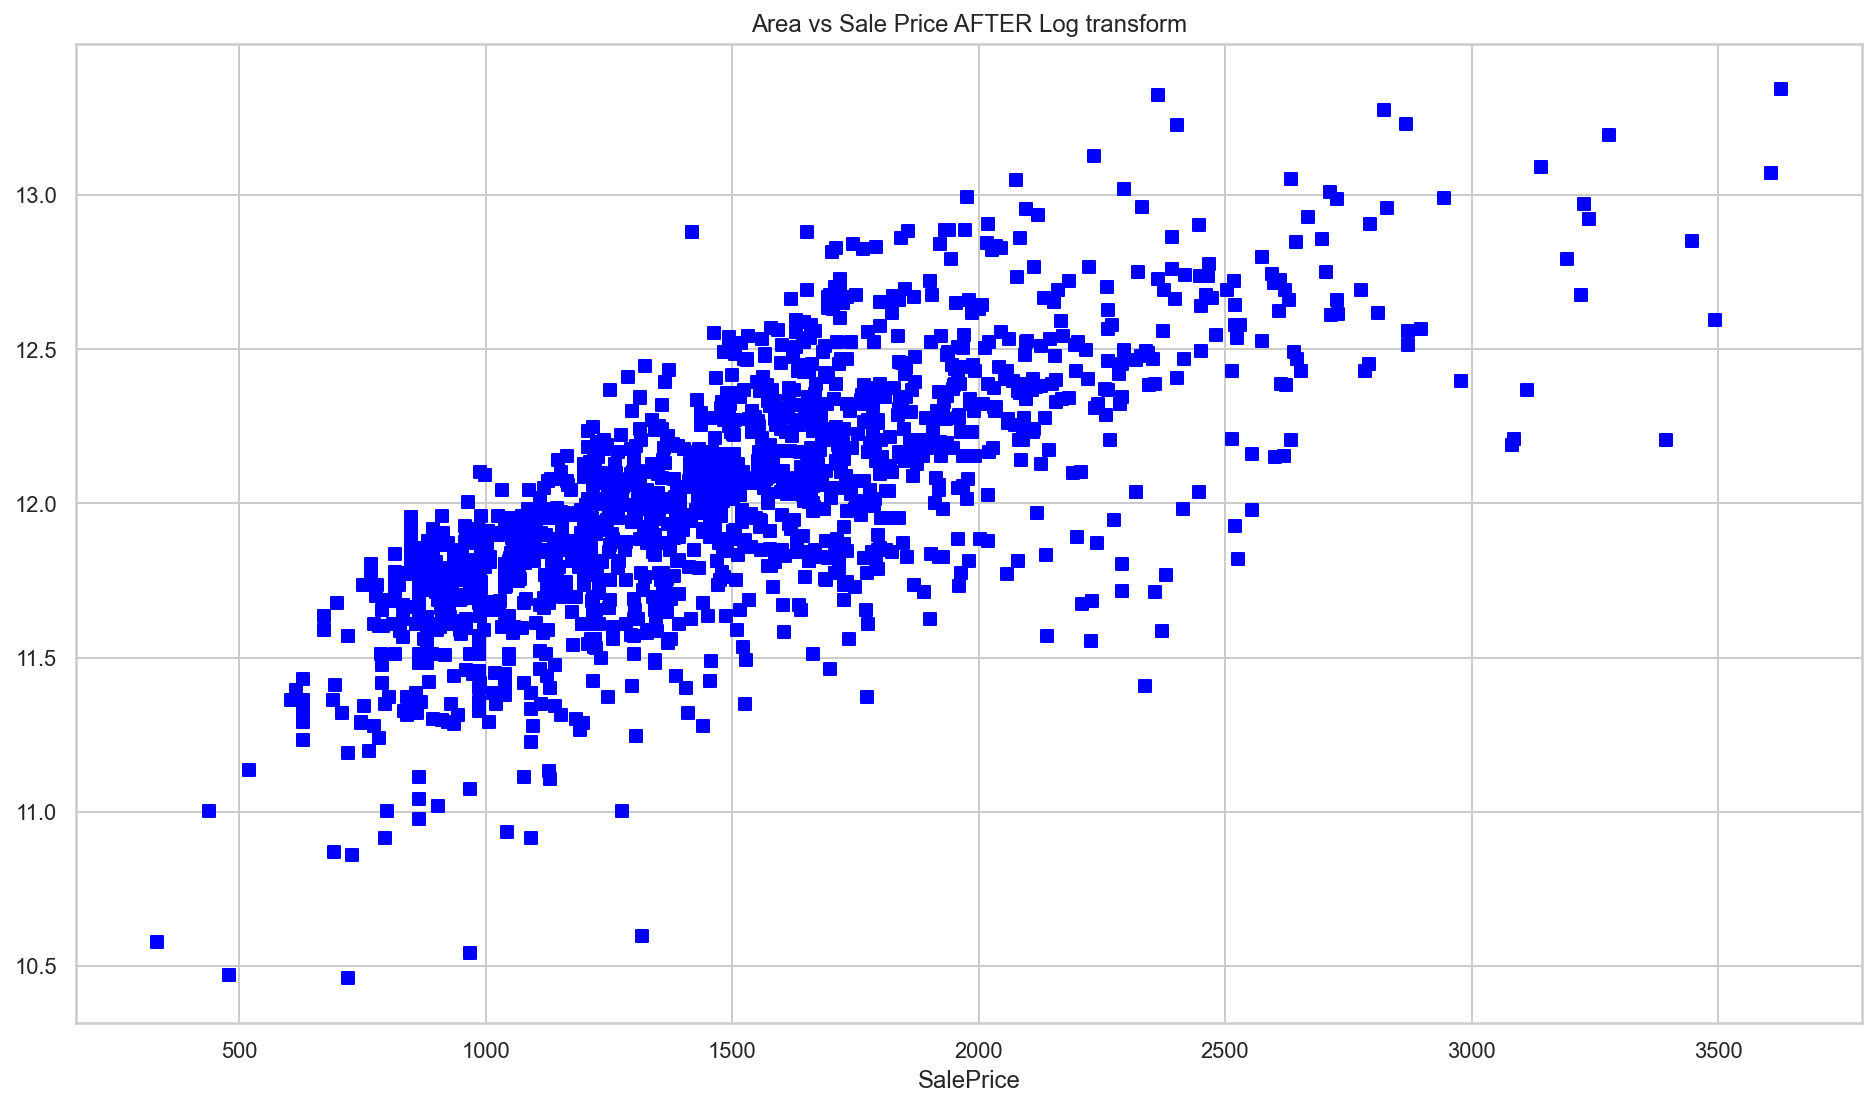

In [17]:
plt.scatter(train.GrLivArea, train.SalePrice, c="blue", marker="s")
plt.title("Area vs Sale Price AFTER Log transform")
plt.xlabel("GrLivArea")
plt.xlabel("SalePrice")
plt.show()

In [18]:
# Alley : data description says NA means "no alley access"
train.loc[:, "Alley"] = train.loc[:, "Alley"].fillna("None")
# BedroomAbvGr : NA most likely means 0
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)

# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")

train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)

# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")

# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")

# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)

# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")

# Fence : data description says NA means "no fence"
train.loc[:, "Fence"] = train.loc[:, "Fence"].fillna("No")

# FireplaceQu : data description says NA means "no fireplace"
train.loc[:, "FireplaceQu"] = train.loc[:, "FireplaceQu"].fillna("No")
train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)

# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")

# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")

train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)

# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)

# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")

# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)

# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")

# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)

# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")

# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)

# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscFeature"] = train.loc[:, "MiscFeature"].fillna("No")
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)

# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)

# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")

# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolQC"] = train.loc[:, "PoolQC"].fillna("No")
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)

# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")

# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)

# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)

# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")

# WoodDeckSF : NA most likely means no wood deck
train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

In [19]:
# Numerical features that are really categories
# TODO: pull into pipeline method
train = train.replace({
    "MSSubClass": {
        20: "SC20",
        30: "SC30",
        40: "SC40",
        45: "SC45",
        50: "SC50",
        60: "SC60", 
        70: "SC70", 
        75: "SC75", 
        80: "SC80",
        85: "SC85",
        90: "SC90",
        120: "SC120",
        150: "SC150",
        160: "SC160",
        180: "SC180",
        190 : "SC190"
    }
})

train = train.replace({
    "MoSold": {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec"
    }
})

In [20]:
# Encode categoricals as ordered number features 
# when there is information in the order
train = train.replace({
    "Alley" : {"Grvl" : 1, "Pave" : 2},
    "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
    "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                     "ALQ" : 5, "GLQ" : 6},
    "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                     "ALQ" : 5, "GLQ" : 6},
    "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
    "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
    "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
    "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                   "Min2" : 6, "Min1" : 7, "Typ" : 8},
    "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
    "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
    "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
    "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
    "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
    "Street" : {"Grvl" : 1, "Pave" : 2},
    "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}
})

In [21]:
# Simplifications of existing features
train["SimplOverallQual"] = train.OverallQual.replace({
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 2,
    6: 2,
    7: 3,
    8: 3,
    9: 3,
    10: 3,
})

train["SimplOverallCond"] = train.OverallCond.replace({
    # Bad
    1: 1,
    2: 1,
    3: 1,
    # Average
    4: 2,
    5: 2,
    6: 2,
    # Good
    7: 3,
    8: 3,
    9: 3,
    10: 3,
})

train["SimplPoolQC"] = train.PoolQC.replace({
    1: 1,
    2: 1,
    3: 2,
    4: 2,
})

train["SimplGarageCond"] = train.GarageCond.replace({
    1: 1,
    2: 1,
    3: 1,
    4: 2,
    5: 2,
})

train["SimplGarageQual"] = train.GarageQual.replace({1 : 1, # bad
                                                     2 : 1, 3 : 1, # average
                                                     4 : 2, 5 : 2 # good
                                                    })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFireplaceQu"] = train.FireplaceQu.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplFunctional"] = train.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major
                                                     5 : 3, 6 : 3, 7 : 3, # minor
                                                     8 : 4 # typical
                                                    })
train["SimplKitchenQual"] = train.KitchenQual.replace({1 : 1, # bad
                                                       2 : 1, 3 : 1, # average
                                                       4 : 2, 5 : 2 # good
                                                      })
train["SimplHeatingQC"] = train.HeatingQC.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplBsmtFinType1"] = train.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtFinType2"] = train.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
train["SimplBsmtCond"] = train.BsmtCond.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplBsmtQual"] = train.BsmtQual.replace({1 : 1, # bad
                                                 2 : 1, 3 : 1, # average
                                                 4 : 2, 5 : 2 # good
                                                })
train["SimplExterCond"] = train.ExterCond.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })
train["SimplExterQual"] = train.ExterQual.replace({1 : 1, # bad
                                                   2 : 1, 3 : 1, # average
                                                   4 : 2, 5 : 2 # good
                                                  })

In [22]:
# Combinations of existing features
# Overall quality of the house
train["OverallGrade"] = train["OverallQual"] * train["OverallCond"]
# Overall quality of the garage
train["GarageGrade"] = train["GarageQual"] * train["GarageCond"]
# Overall quality of the exterior
train["ExterGrade"] = train["ExterQual"] * train["ExterCond"]
# Overall kitchen score
train["KitchenScore"] = train["KitchenAbvGr"] * train["KitchenQual"]
# Overall fireplace score
train["FireplaceScore"] = train["Fireplaces"] * train["FireplaceQu"]
# Overall garage score
train["GarageScore"] = train["GarageArea"] * train["GarageQual"]
# Overall pool score
train["PoolScore"] = train["PoolArea"] * train["PoolQC"]
# Simplified overall quality of the house
train["SimplOverallGrade"] = train["SimplOverallQual"] * train["SimplOverallCond"]
# Simplified overall quality of the exterior
train["SimplExterGrade"] = train["SimplExterQual"] * train["SimplExterCond"]
# Simplified overall pool score
train["SimplPoolScore"] = train["PoolArea"] * train["SimplPoolQC"]
# Simplified overall garage score
train["SimplGarageScore"] = train["GarageArea"] * train["SimplGarageQual"]
# Simplified overall fireplace score
train["SimplFireplaceScore"] = train["Fireplaces"] * train["SimplFireplaceQu"]
# Simplified overall kitchen score
train["SimplKitchenScore"] = train["KitchenAbvGr"] * train["SimplKitchenQual"]
# Total number of bathrooms
train["TotalBath"] = train["BsmtFullBath"] + (0.5 * train["BsmtHalfBath"]) + \
train["FullBath"] + (0.5 * train["HalfBath"])
# Total SF for house (incl. basement)
train["AllSF"] = train["GrLivArea"] + train["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
train["AllFlrsSF"] = train["1stFlrSF"] + train["2ndFlrSF"]
# Total SF for porch
train["AllPorchSF"] = train["OpenPorchSF"] + train["EnclosedPorch"] + \
train["3SsnPorch"] + train["ScreenPorch"]
# Has masonry veneer or not
train["HasMasVnr"] = train.MasVnrType.replace({"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, 
                                               "Stone" : 1, "None" : 0})
# House completed before sale or not
train["BoughtOffPlan"] = train.SaleCondition.replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, 
                                                      "Family" : 0, "Normal" : 0, "Partial" : 1})

#### Polynomials of top 10 features

Based on correlation with target

In [28]:
feature_correlations = train.corr()
top_10_price_correlated_features = feature_correlations.sort_values(by="SalePrice", ascending=False).SalePrice.head(11)
top_10_price_correlated_features

SalePrice           1.000000
OverallQual         0.819240
AllSF               0.817272
AllFlrsSF           0.729421
GrLivArea           0.718844
SimplOverallQual    0.707934
ExterQual           0.680947
GarageCars          0.680408
TotalBath           0.672929
KitchenQual         0.667174
GarageScore         0.656822
Name: SalePrice, dtype: float64

In [30]:
for col in list(top_10_price_correlated_features.index):
    if col == "SalePrice":
        continue
    
    train[f"{col}-s2"] = train[col] ** 2
    train[f"{col}-s3"] = train[col] ** 3
    train[f"{col}-sq"] = np.sqrt(train[col])

#### Split numerical and categorical features

In [40]:
categorical_features = train.select_dtypes(include=["object"]).columns
numerical_features = train.select_dtypes(exclude=["object"]).columns.drop("SalePrice")

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

Numerical features: 117
Categorical features: 26


In [42]:
train_num = train[numerical_features]
train_cat = train[categorical_features]

In [43]:
# Handle missing values in numerical features by using the median
print(f"Missing numerical values: {train_num.isnull().values.sum()}")
train_num = train_num.fillna(train_num.median())

print(f"Remaining missing numerical values: {train_num.isnull().values.sum()}")

Missing numerical values: 81
Remaining missing numerical values: 0


In [45]:
## Log transform skewed numerical features to lessen impact of outliers

# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed

skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]

skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

In [46]:
## One hot encode categorical variables
train_cat = pd.get_dummies(train_cat)

In [47]:
train = pd.concat([train_num, train_cat], axis=1)
print(f"Number of features: {train.shape[1]}")

Number of features: 319


## Modelling

* Split dataset
* Standardisation (don't want to fit on observations that will be in the test set)

### Modelling techniques tried

* Linear regression
* Ridge Regression (L2)
* LASSO (L1)
* ElasticNET (L1 AND L2)


In [48]:
# Split training set
X_train, X_test, y_train, y_test = train_test_split(
    train,
    y,
    test_size=0.3,
    random_state=0
)

print("X_train", str(X_train.shape))
print("X_test", str(X_test.shape))
print("y_train", str(y_train.shape))
print("y_test", str(y_test.shape))

X_train (1019, 319)
X_test (437, 319)
y_train (1019,)
y_test (437,)


In [49]:
# Standard scale the features
# Done after partitioning to avoid fitting scaler to observations in the test set
# Should the scaler be pickled for deployment use cases then?
scaler = StandardScaler()
X_train.loc[:, numerical_features] = scaler.fit_transform(X_train.loc[:, numerical_features])
X_test.loc[:, numerical_features] = scaler.transform(X_test.loc[:, numerical_features])

/Users/rocco.cammisola/anaconda/envs/kaggle_house_prices/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/Users/rocco.cammisola/anaconda/envs/kaggle_house_prices/lib/python3.7/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [50]:
# Official error measure for scoring: RMSE
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def rmse_cv_train(model):
    return np.sqrt(-cross_val_score(model, 
                                    X_train, 
                                    y_train, 
                                    scoring=scorer, cv=10))


def rmse_cv_test(model):
    return np.sqrt(-cross_val_score(model, 
                                    X_test, 
                                    y_test, 
                                    scoring=scorer, cv=10))


## Linear regression without regularisation


RMSE on Training set: 0.3883547297789364
RMSE on Test set: 0.4259187106557699


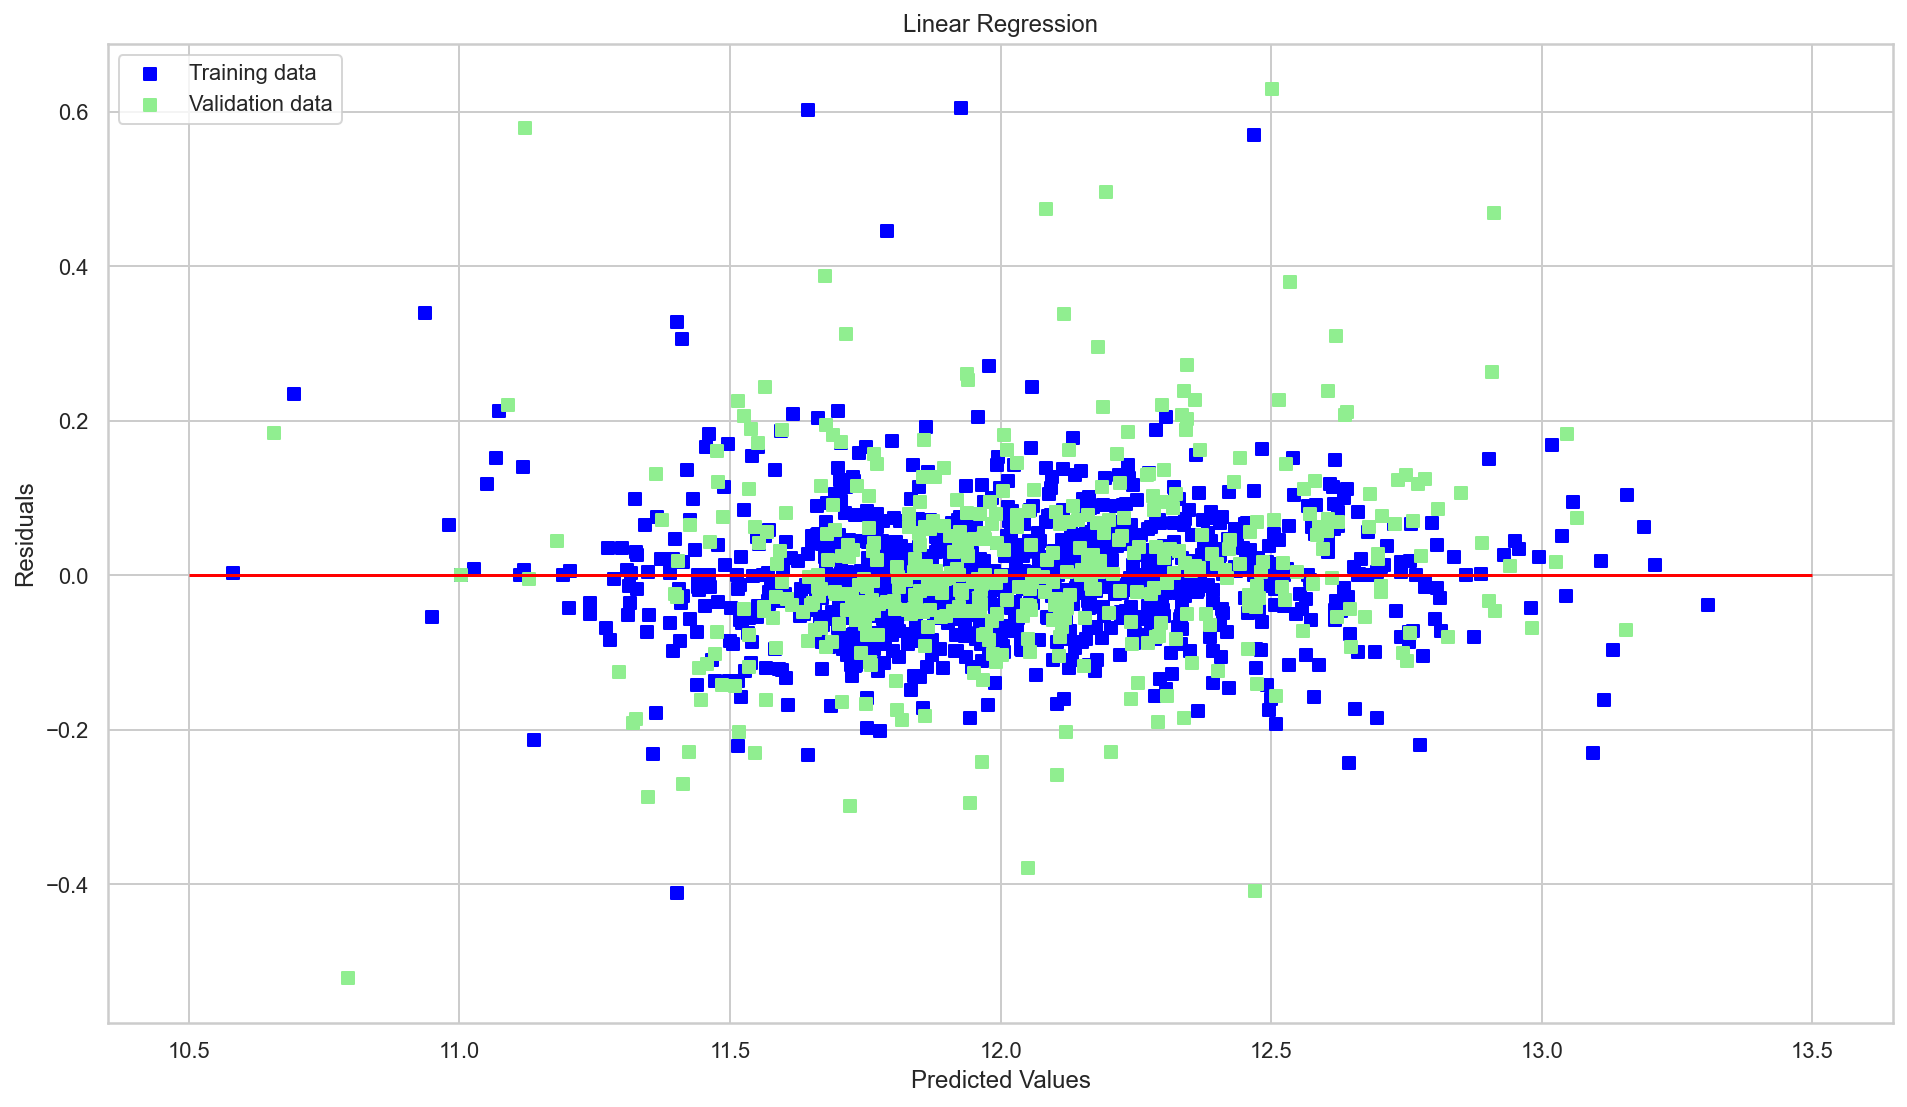

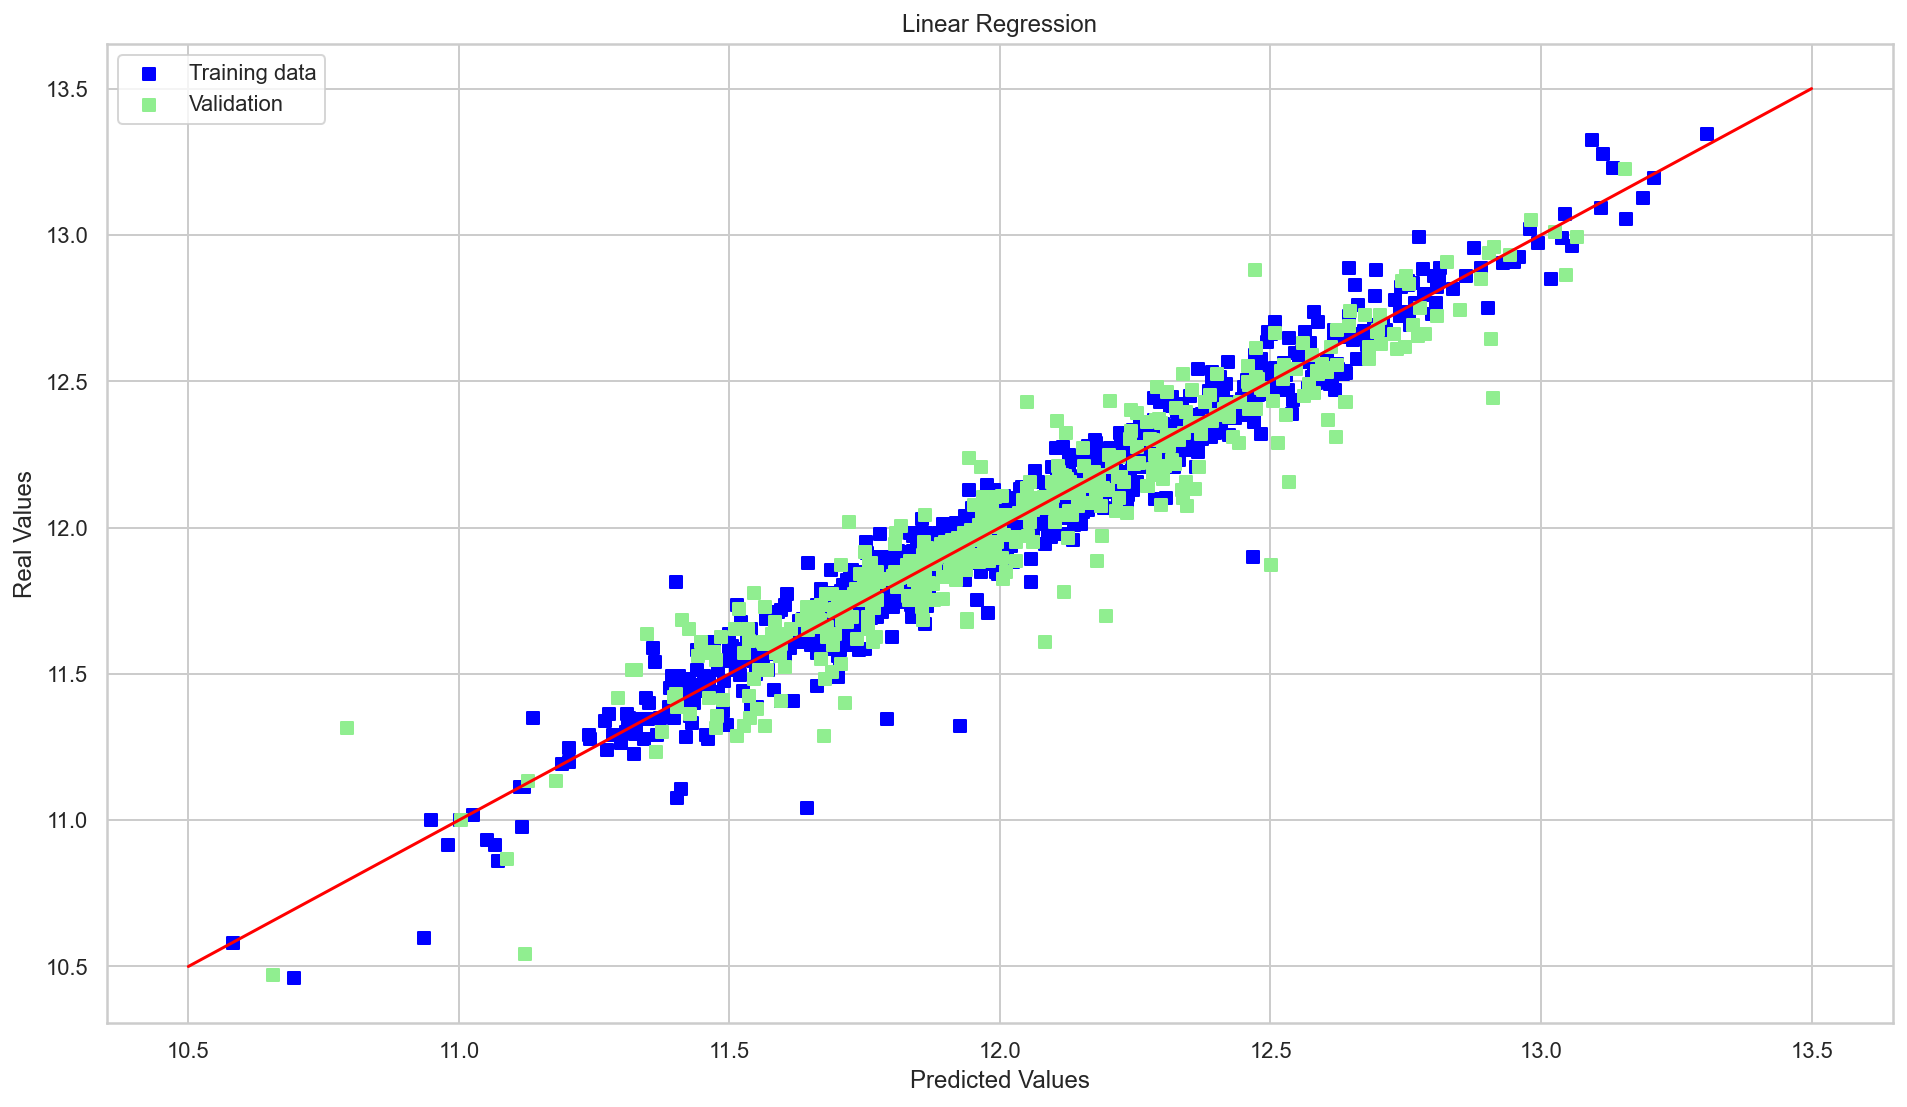

In [53]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

print(f"RMSE on Training set: {rmse_cv_train(linear_regression).mean()}")
print(f"RMSE on Test set: {rmse_cv_test(linear_regression).mean()}")

y_train_pred = linear_regression.predict(X_train)
y_test_pred = linear_regression.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, 
            y_train_pred - y_train, 
            c="blue", 
            marker="s", 
            label="Training data")
plt.scatter(y_test_pred, 
            y_test_pred - y_test, 
            c="lightgreen", 
            marker="s", 
            label="Validation data")
plt.title("Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, 
            y_train, 
            c="blue", 
            marker="s", 
            label="Training data")
plt.scatter(y_test_pred, 
            y_test, 
            c="lightgreen", 
            marker="s", 
            label="Validation")
plt.title("Linear Regression")
plt.xlabel("Predicted Values")
plt.ylabel("Real Values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()

## Linear Regression with Ridge Regression (L2 Penalty)

* Regularisation is a good way to hadnle collinearity, filter out noise and prevent overfitting.
* L2 penalty add the squared sum of weights to cost function

Best alpha 30.0
Re-fit with alphas around the best alpha
Best alpha 24.0
Ridge RMSE on Training set: 0.11541575243477839
Ridge RMSE on Test set: 0.11642721377799556


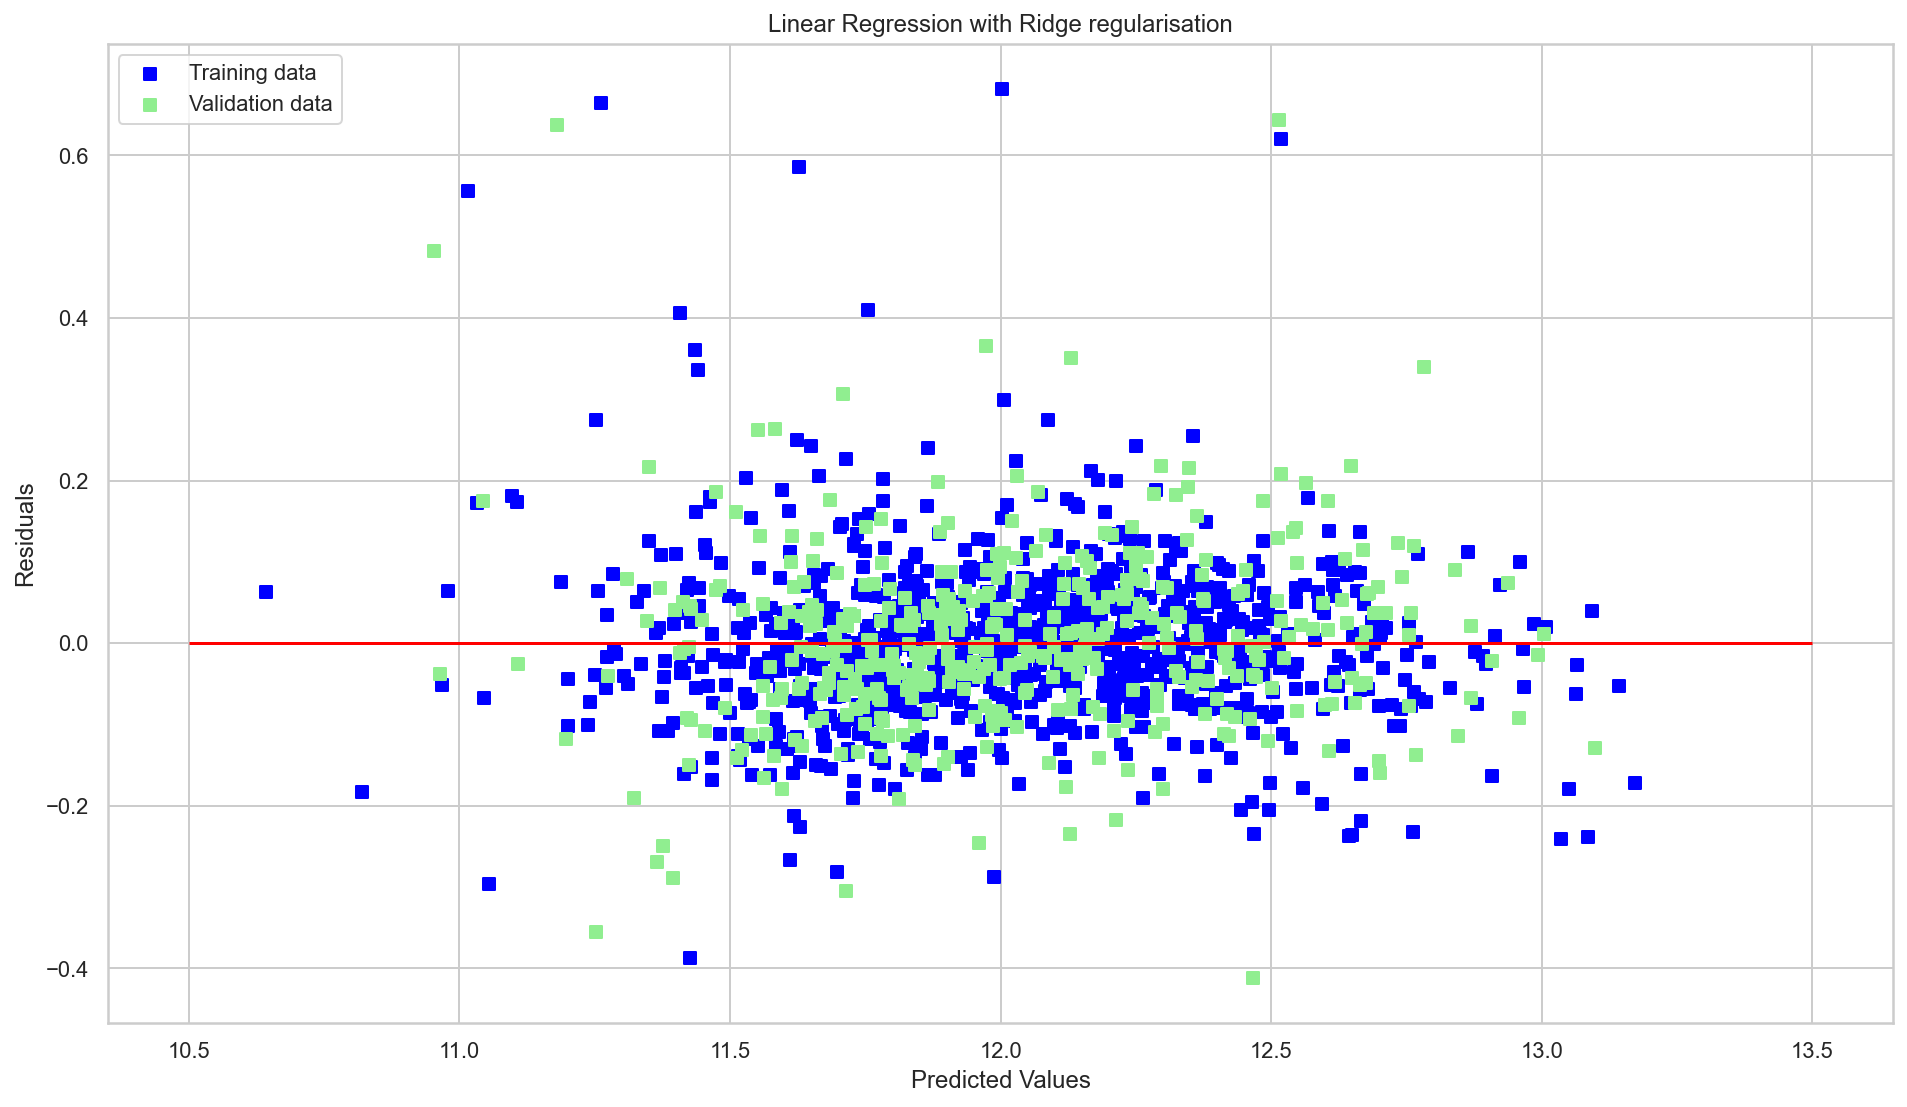

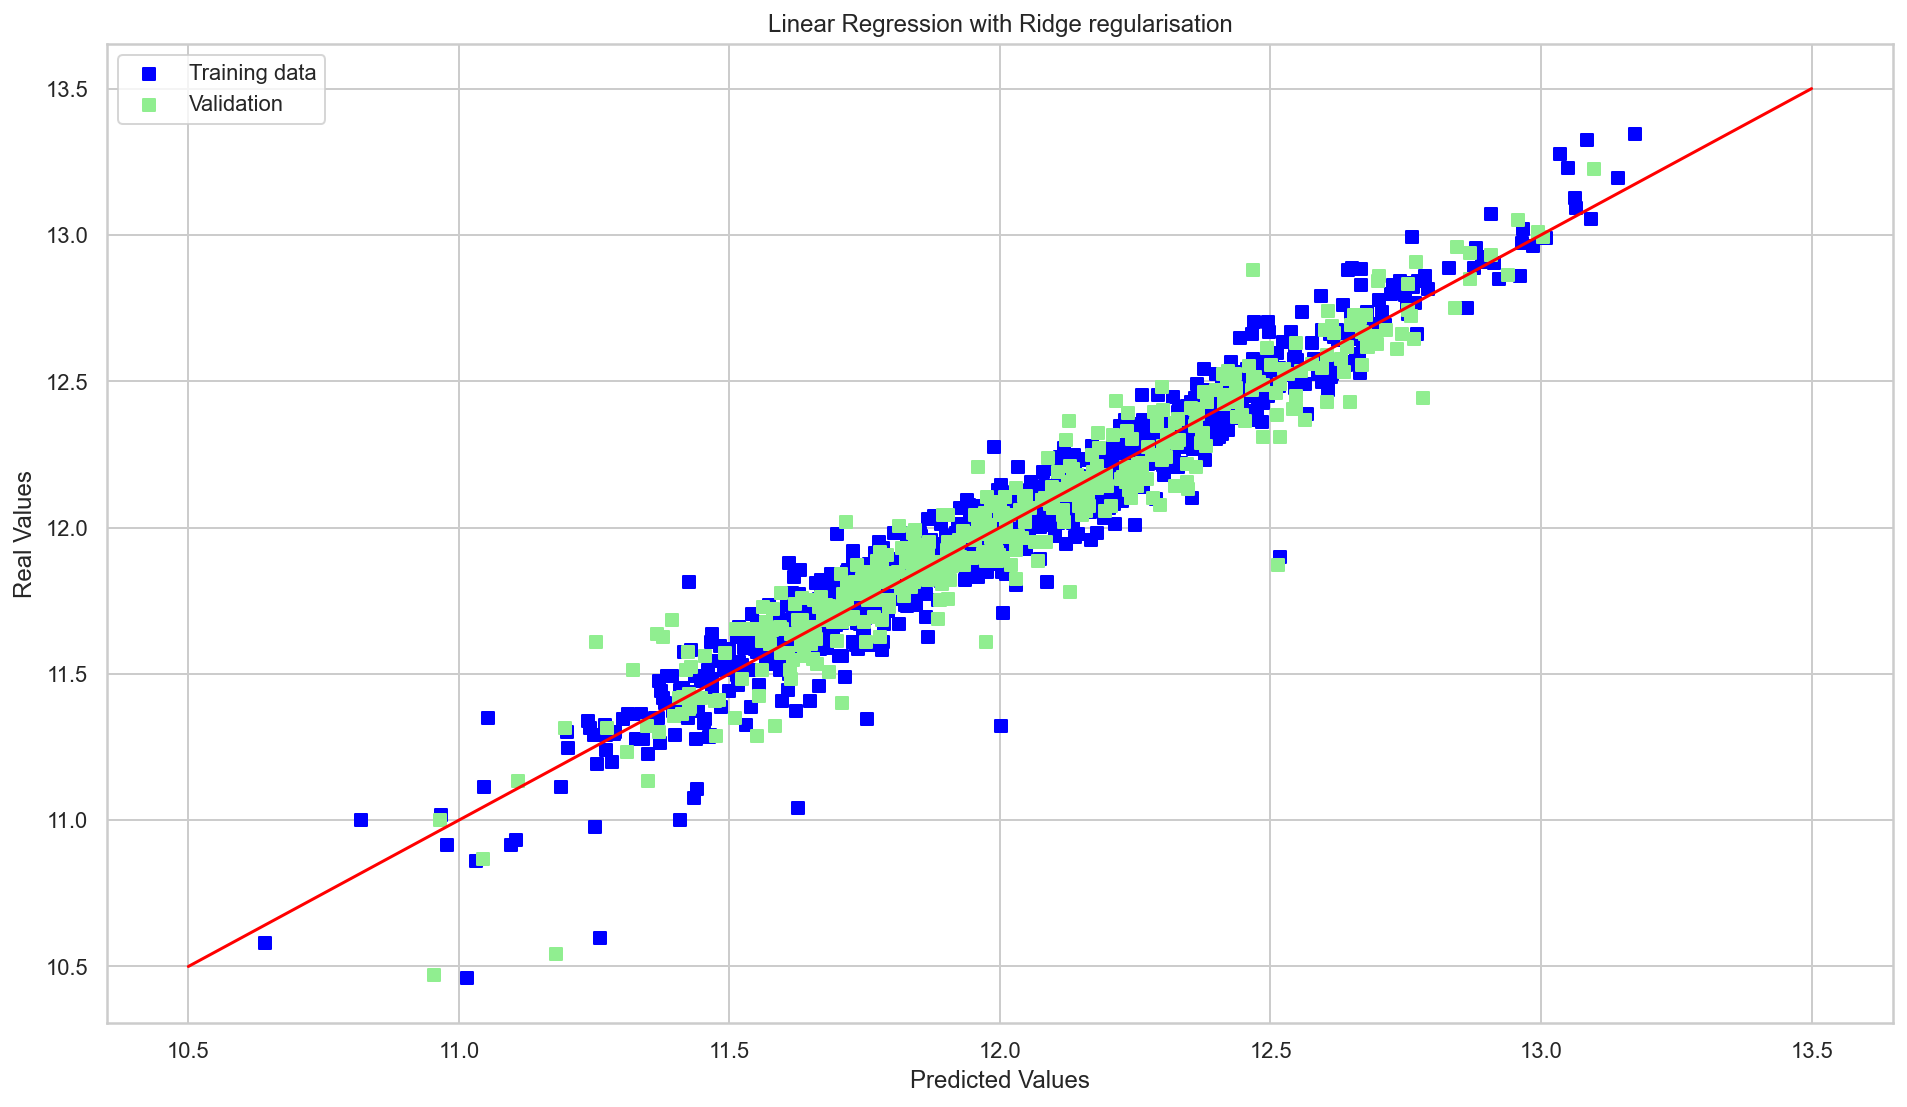

Ridge picked 316 features and eliminated the other 3 features


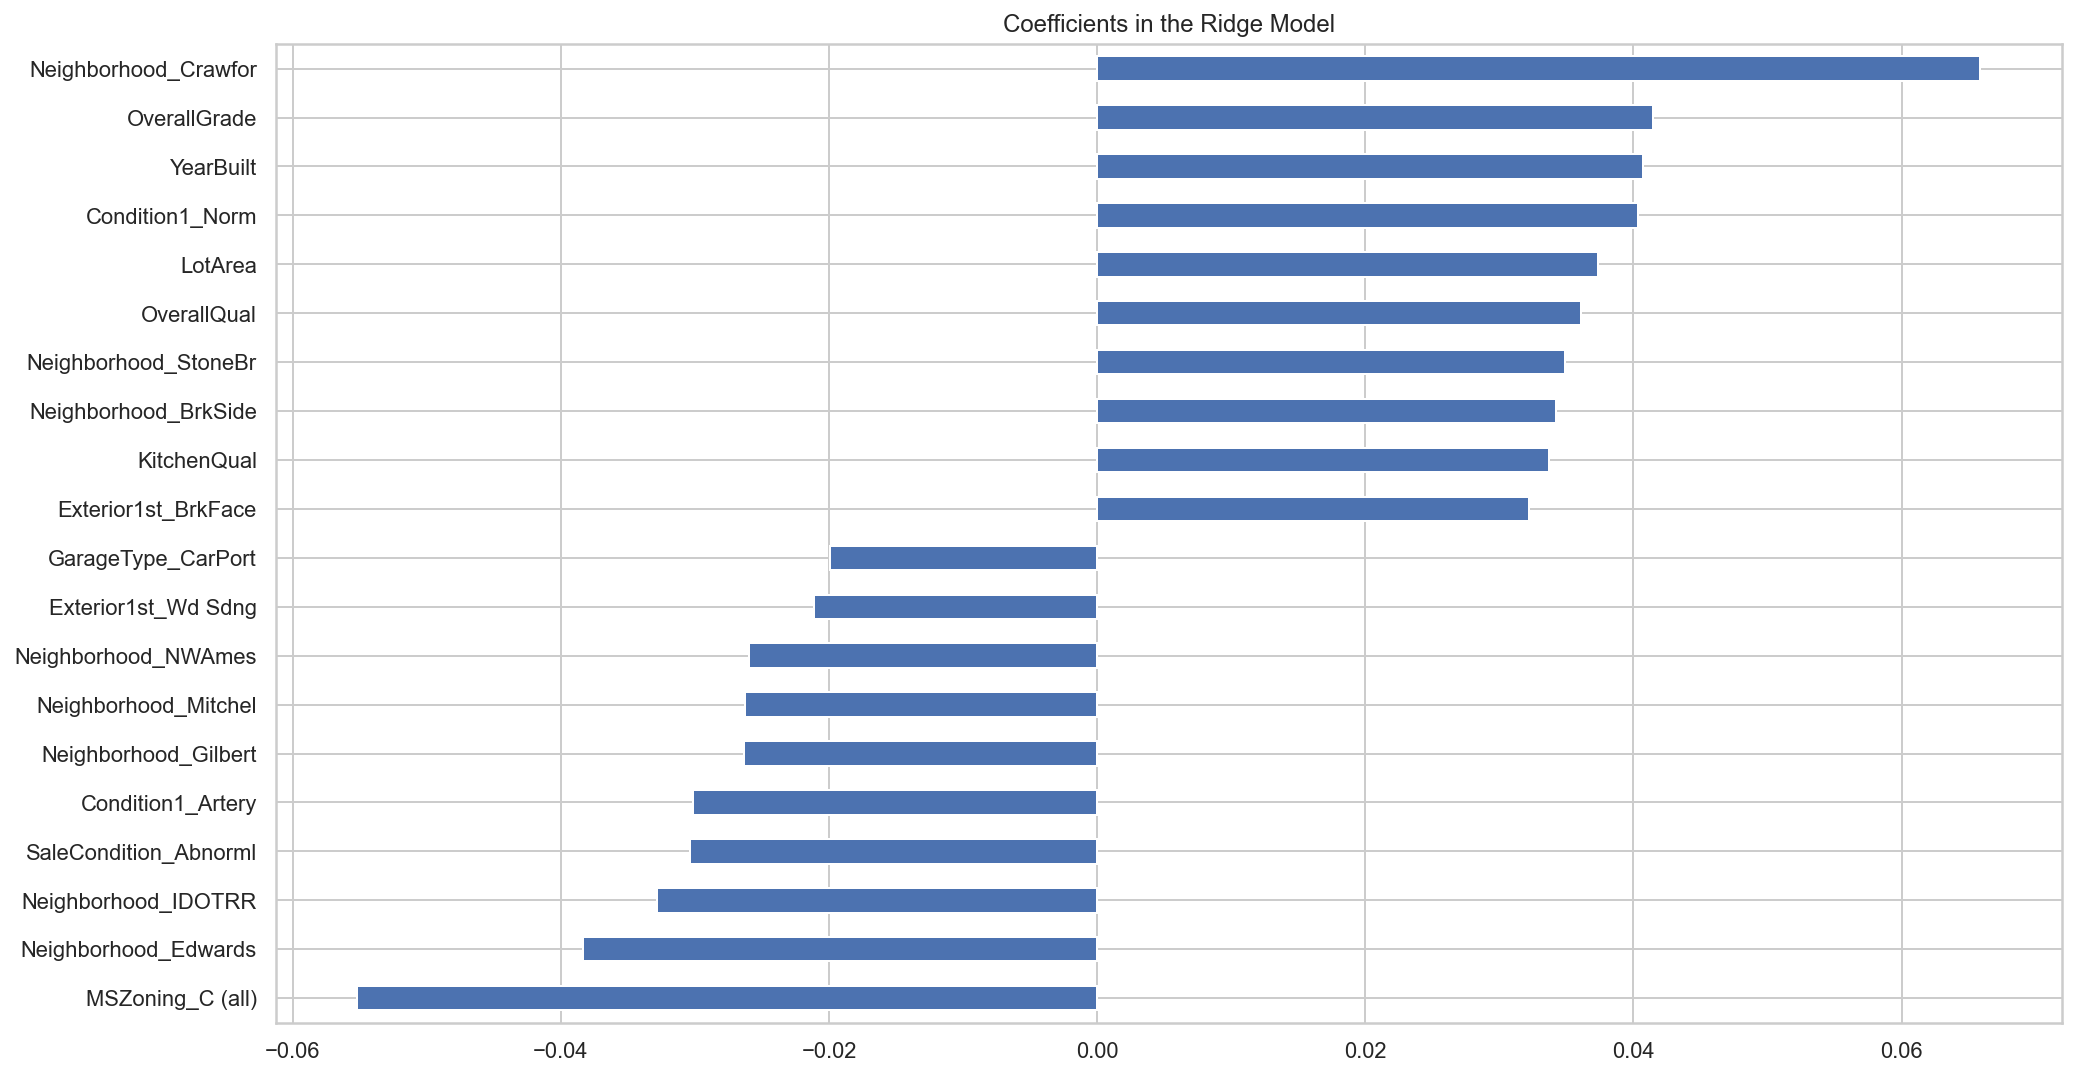

In [60]:
ridge_regression = RidgeCV(
    alphas=[0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60]
)
ridge_regression.fit(X_train, y_train)
best_alpha = ridge_regression.alpha_
print(f"Best alpha {best_alpha}")


print("Re-fit with alphas around the best alpha")
ridge_regression = RidgeCV(
    alphas=[
        best_alpha * .6,
        best_alpha * .65,
        best_alpha * .7,
        best_alpha * .75,
        best_alpha * .8,
        best_alpha * .85,
        best_alpha * .9,
        best_alpha * .9,
        best_alpha * .95,
        best_alpha,
        best_alpha * 1.05,
        best_alpha * 1.1,
        best_alpha * 1.15,
        best_alpha * 1.2,
        best_alpha * 1.25,
        best_alpha * 1.3,
        best_alpha * 1.35,
        best_alpha * 1.4,
    ],
    cv=10
)

ridge_regression.fit(X_train, y_train)

best_alpha = ridge_regression.alpha_
print(f"Best alpha {best_alpha}")

print(f"Ridge RMSE on Training set: {rmse_cv_train(ridge_regression).mean()}")
print(f"Ridge RMSE on Test set: {rmse_cv_test(ridge_regression).mean()}")

y_train_pred = ridge_regression.predict(X_train)
y_test_pred = ridge_regression.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, 
            y_train_pred - y_train, 
            c="blue", 
            marker="s", 
            label="Training data")
plt.scatter(y_test_pred, 
            y_test_pred - y_test, 
            c="lightgreen", 
            marker="s", 
            label="Validation data")
plt.title("Linear Regression with Ridge regularisation")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, 
            y_train, 
            c="blue", 
            marker="s", 
            label="Training data")
plt.scatter(y_test_pred, 
            y_test, 
            c="lightgreen", 
            marker="s", 
            label="Validation")
plt.title("Linear Regression with Ridge regularisation")
plt.xlabel("Predicted Values")
plt.ylabel("Real Values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()


## Plot important coefficients
coefs = pd.Series(ridge_regression.coef_, index=X_train.columns)
print(f"Ridge picked {sum(coefs != 0)} features and eliminated the other {sum(coefs == 0)} features")
important_coefficients = pd.concat([coefs.sort_values().head(10),
                                   coefs.sort_values().tail(10)])
important_coefficients.plot(kind="barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

Results:
* Better RMSE for Ridge
* Small difference between training and test suggests that overfitting has been eliminated
* Ridge used almost all of the features (only 3 dropped)

TODO: Understand the coefficient plot (if possible?)

## LASSO Regression

Least Absolute Shrinkage and Selection Operator.

Alternative regularisation method, L1 Regularisation, use the absolute value of weights rather than squares. 

Most weights will be 0. Useful in high dimensional dataset where most features are irrelevant.

Hypothesis: more efficient than Ridge Regression.

Best alpha 0.0006
Re-fit with alphas around the best alpha
Best alpha 0.0006
Ridge RMSE on Training set: 0.11411741961782249
Ridge RMSE on Test set: 0.11583213221750706


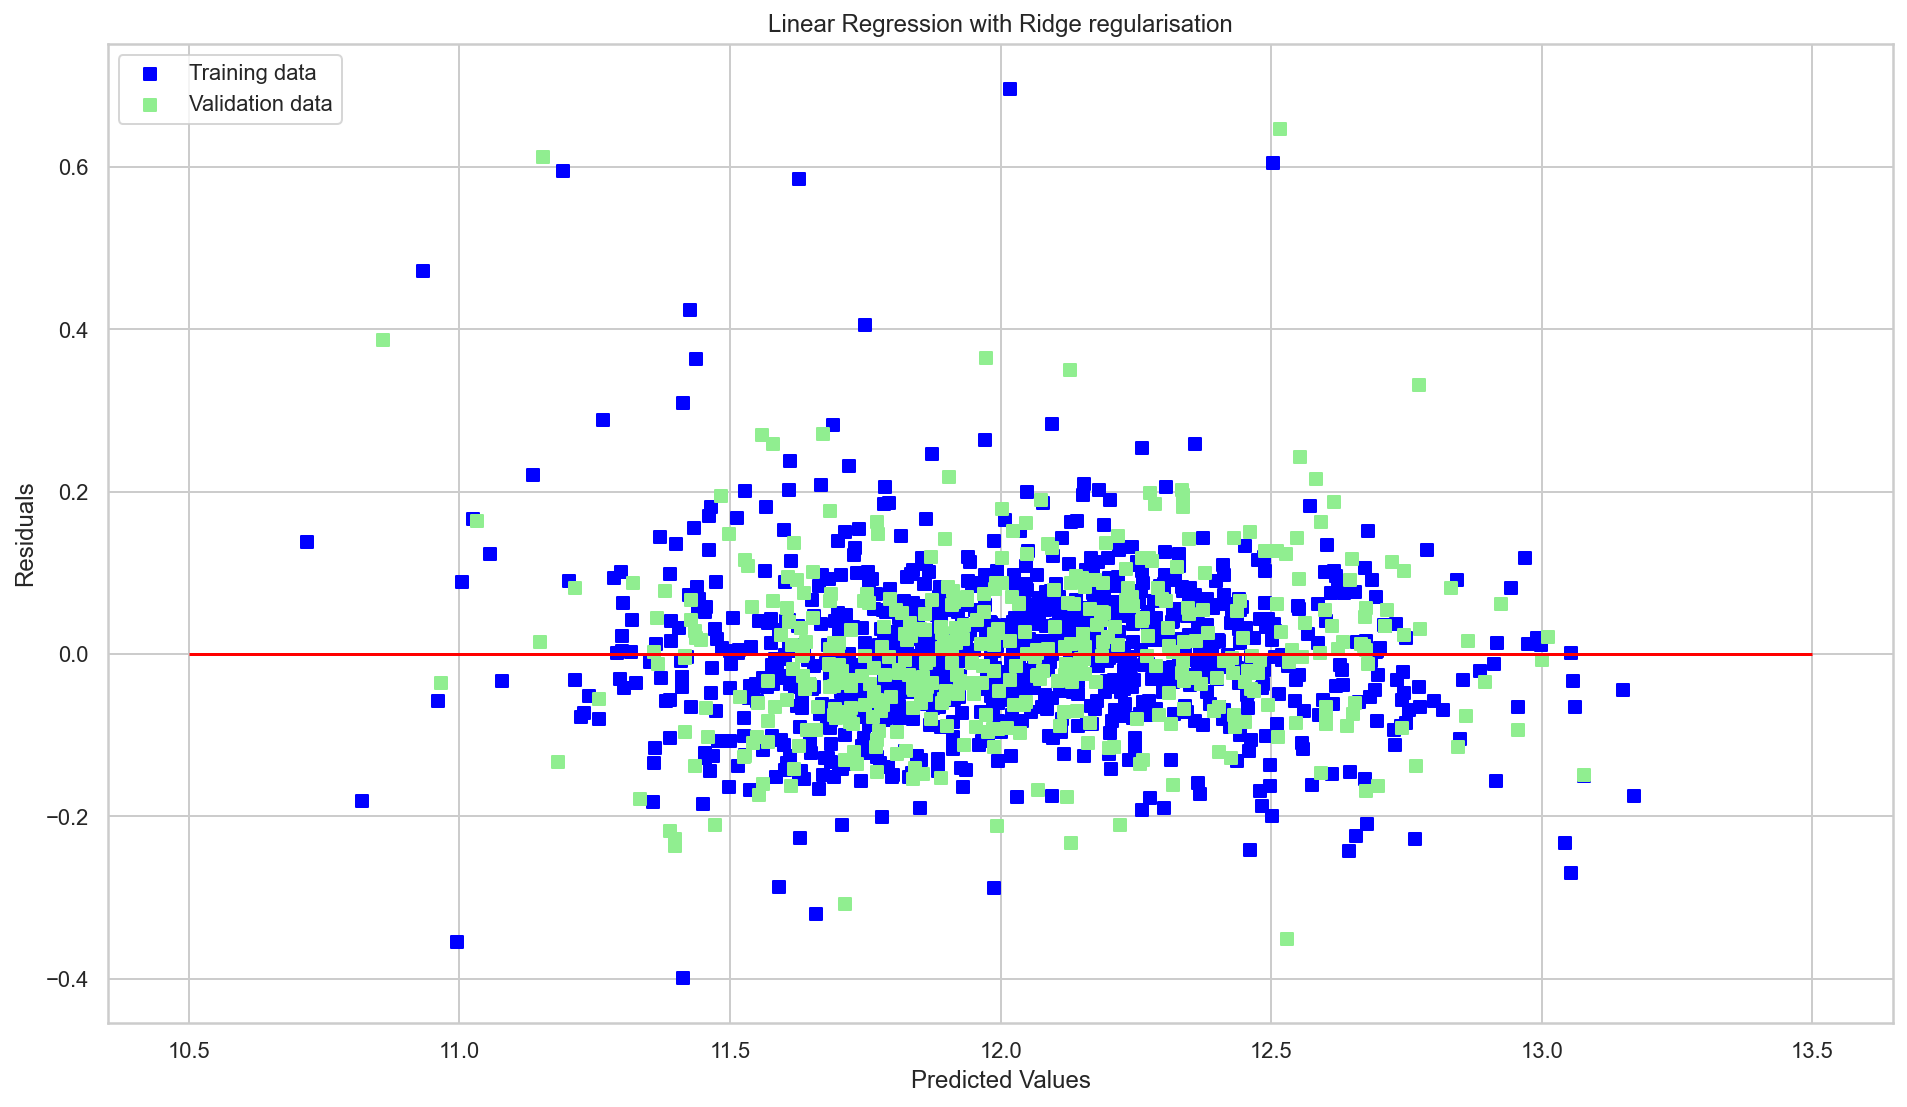

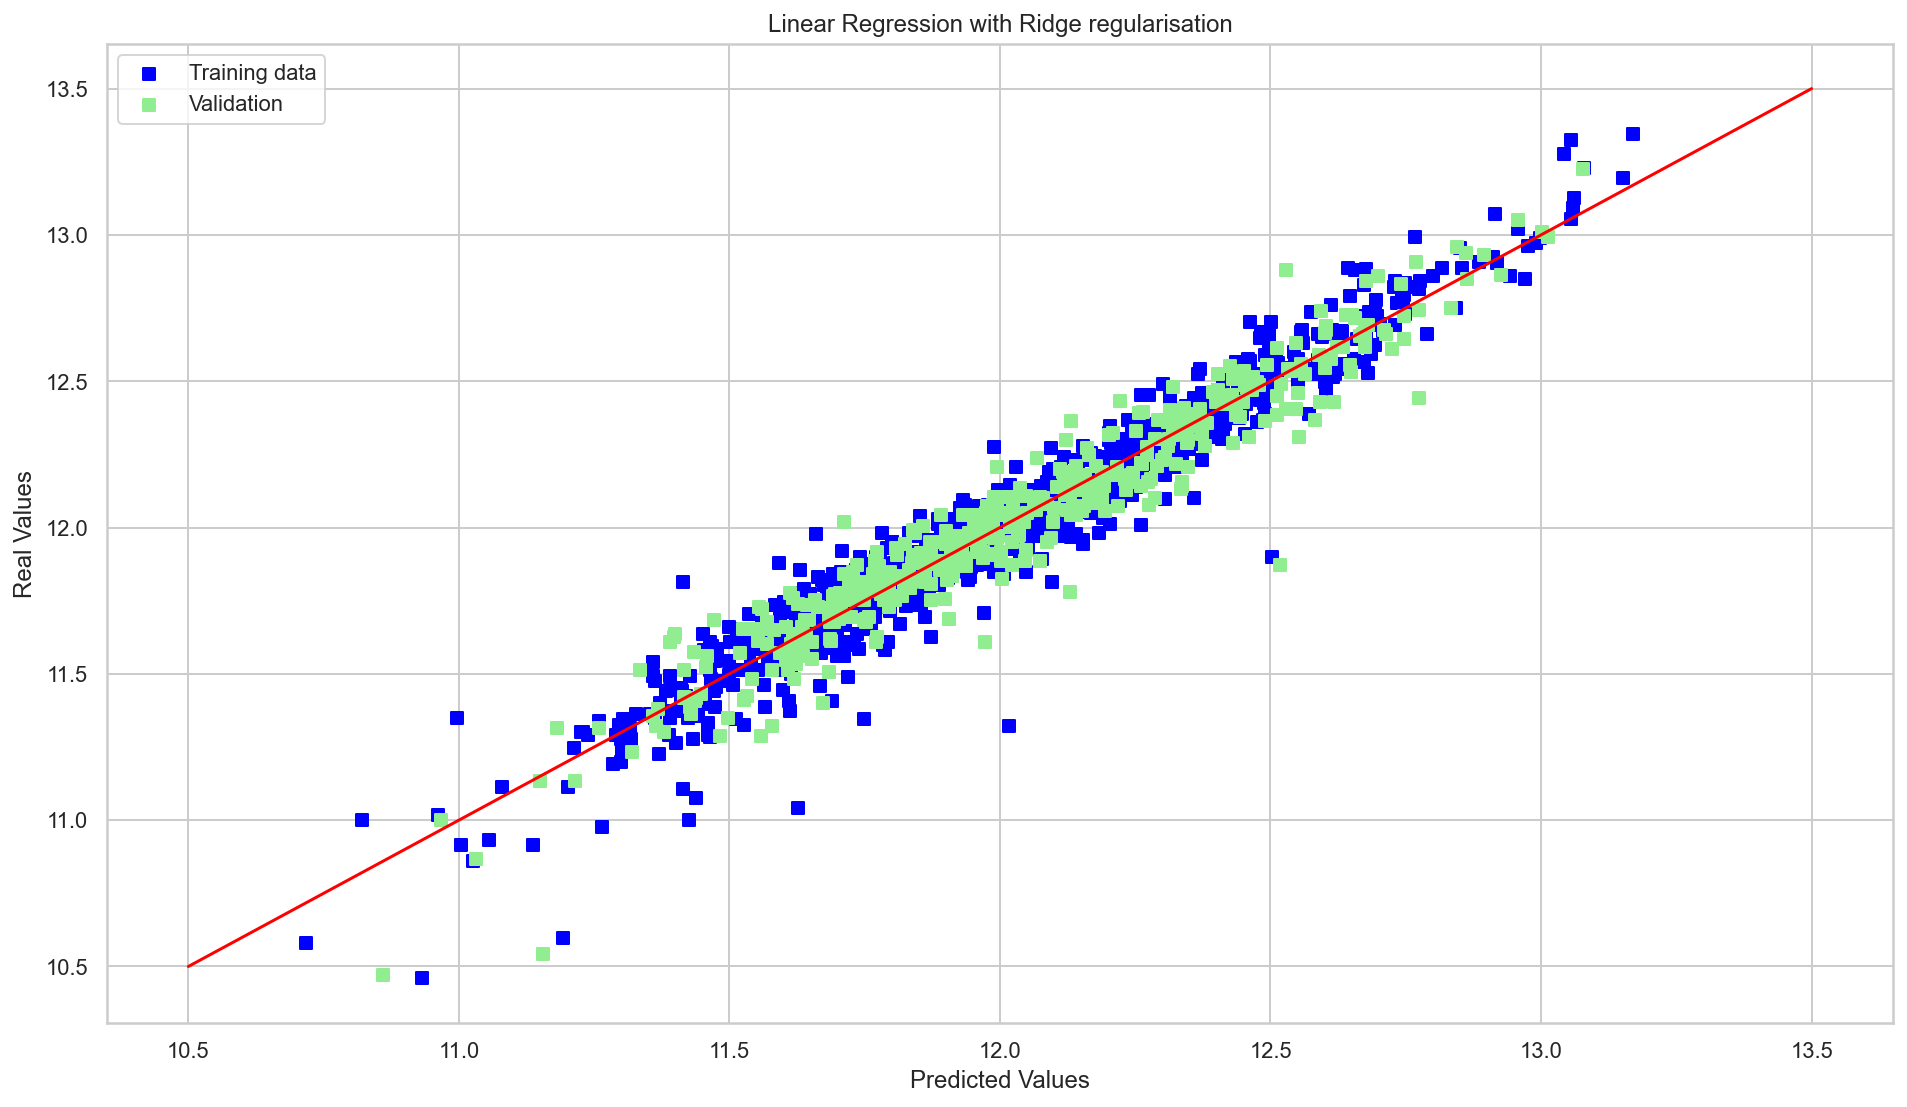

Ridge picked 111 features and eliminated the other 208 features


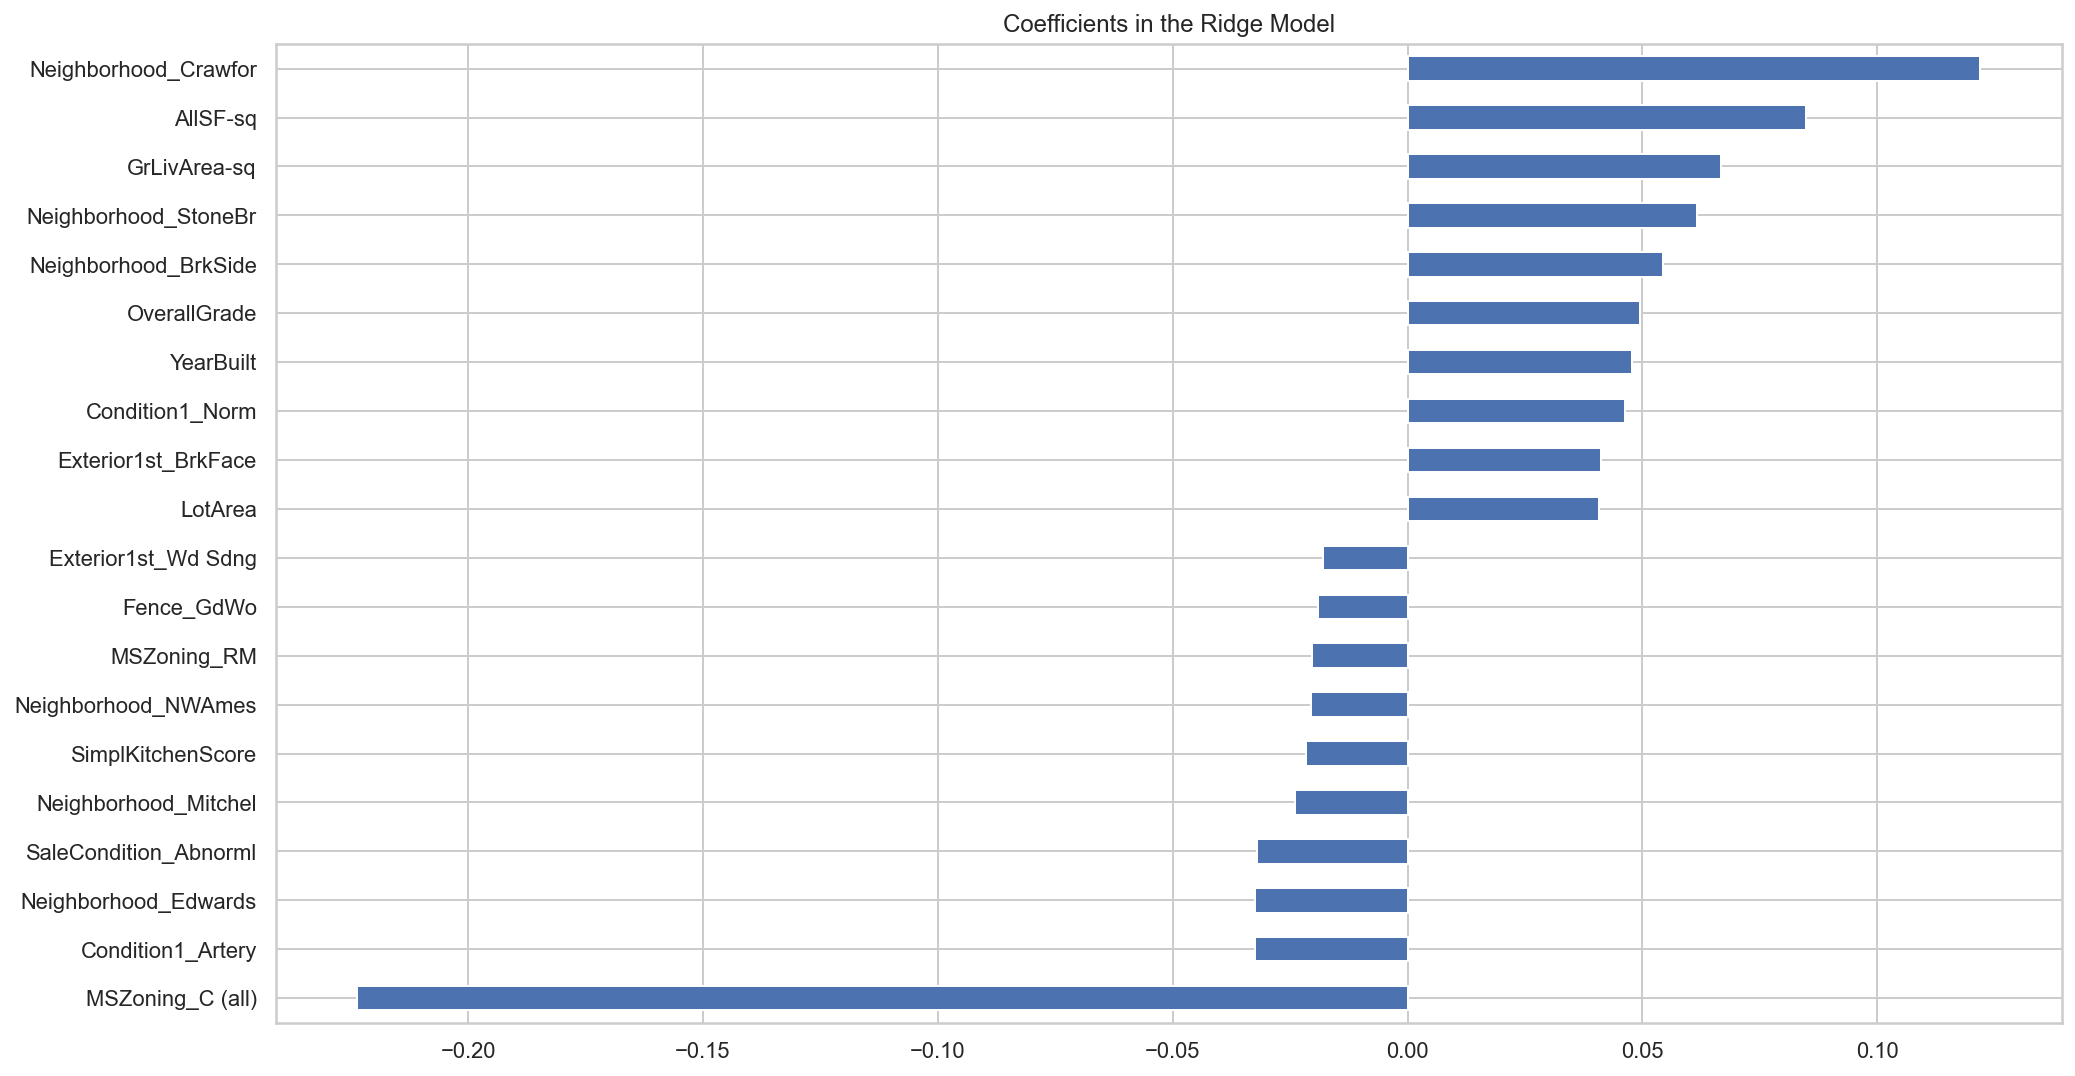

In [62]:
lasso_regression = LassoCV(
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
    max_iter=50000,
    cv=10
)
lasso_regression.fit(X_train, y_train)
best_alpha = lasso_regression.alpha_
print(f"Best alpha {best_alpha}")


print("Re-fit with alphas around the best alpha")
lasso_regression = LassoCV(
    alphas=[
        best_alpha * .6,
        best_alpha * .65,
        best_alpha * .7,
        best_alpha * .75,
        best_alpha * .8,
        best_alpha * .85,
        best_alpha * .9,
        best_alpha * .9,
        best_alpha * .95,
        best_alpha,
        best_alpha * 1.05,
        best_alpha * 1.1,
        best_alpha * 1.15,
        best_alpha * 1.2,
        best_alpha * 1.25,
        best_alpha * 1.3,
        best_alpha * 1.35,
        best_alpha * 1.4,
    ],
    max_iter=50000,
    cv=10
)

lasso_regression.fit(X_train, y_train)

best_alpha = lasso_regression.alpha_
print(f"Best alpha {best_alpha}")

print(f"LASSO RMSE on Training set: {rmse_cv_train(lasso_regression).mean()}")
print(f"LASSO RMSE on Test set: {rmse_cv_test(lasso_regression).mean()}")

y_train_pred = lasso_regression.predict(X_train)
y_test_pred = lasso_regression.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, 
            y_train_pred - y_train, 
            c="blue", 
            marker="s", 
            label="Training data")
plt.scatter(y_test_pred, 
            y_test_pred - y_test, 
            c="lightgreen", 
            marker="s", 
            label="Validation data")
plt.title("Linear Regression with LASSO regularisation")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, 
            y_train, 
            c="blue", 
            marker="s", 
            label="Training data")
plt.scatter(y_test_pred, 
            y_test, 
            c="lightgreen", 
            marker="s", 
            label="Validation")
plt.title("Linear Regression with Ridge regularisation")
plt.xlabel("Predicted Values")
plt.ylabel("Real Values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()


## Plot important coefficients
coefs = pd.Series(lasso_regression.coef_, index=X_train.columns)
print(f"LASSO picked {sum(coefs != 0)} features and eliminated the other {sum(coefs == 0)} features")
important_coefficients = pd.concat([coefs.sort_values().head(10),
                                   coefs.sort_values().tail(10)])
important_coefficients.plot(kind="barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

## ElasticNET

* Compromise between L1 and L2 penalties

/Users/rocco.cammisola/anaconda/envs/kaggle_house_prices/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05083181033991657, tolerance: 0.01426910245430051
  tol, rng, random, positive)
/Users/rocco.cammisola/anaconda/envs/kaggle_house_prices/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.04478905817296219, tolerance: 0.014439328514818318
  tol, rng, random, positive)


Best L1 Ratio 1.0
Best alpha 0.0006
Re-fit with alphas around the best alpha
Best L1 Ratio 1.15
Best alpha 0.00054
ElasticNet RMSE on Training set: 0.11412390514661364
ElasticNet RMSE on Test set: 0.11581727694249426


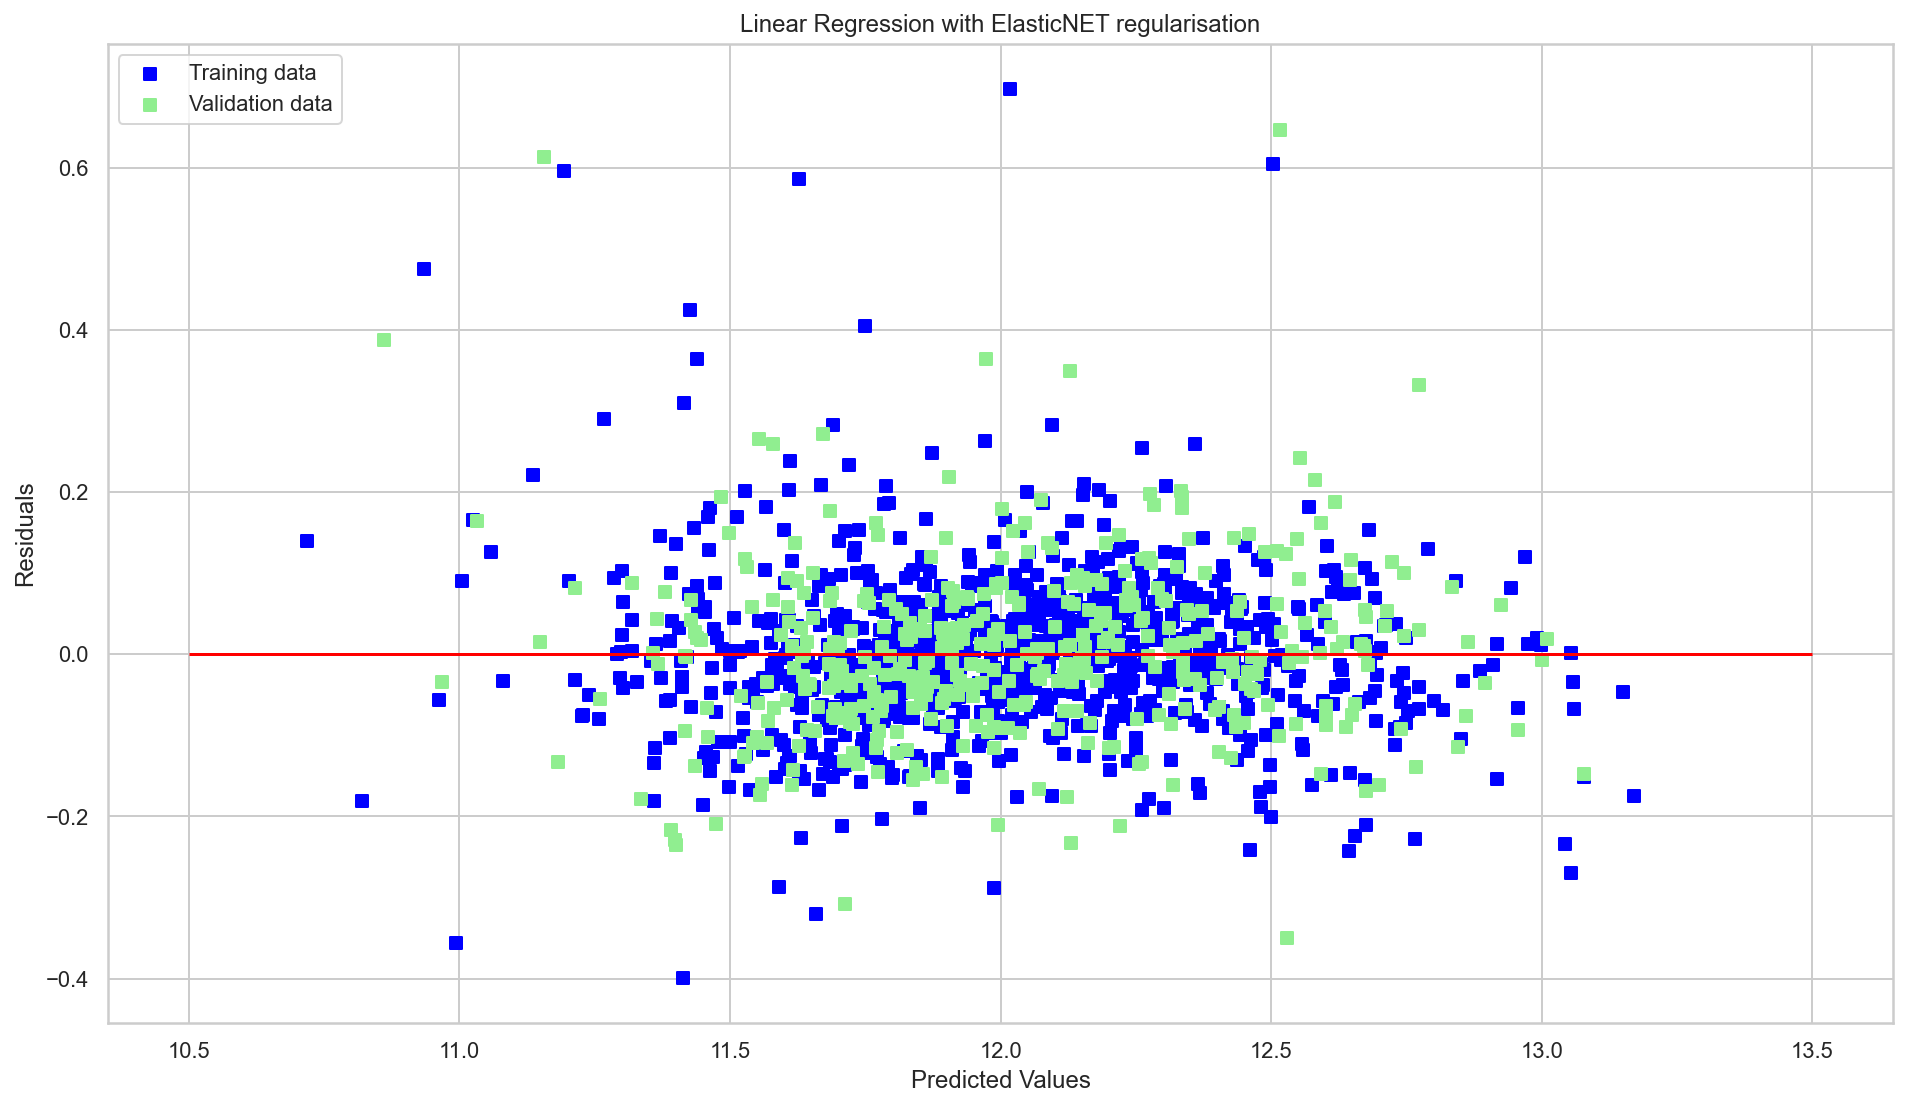

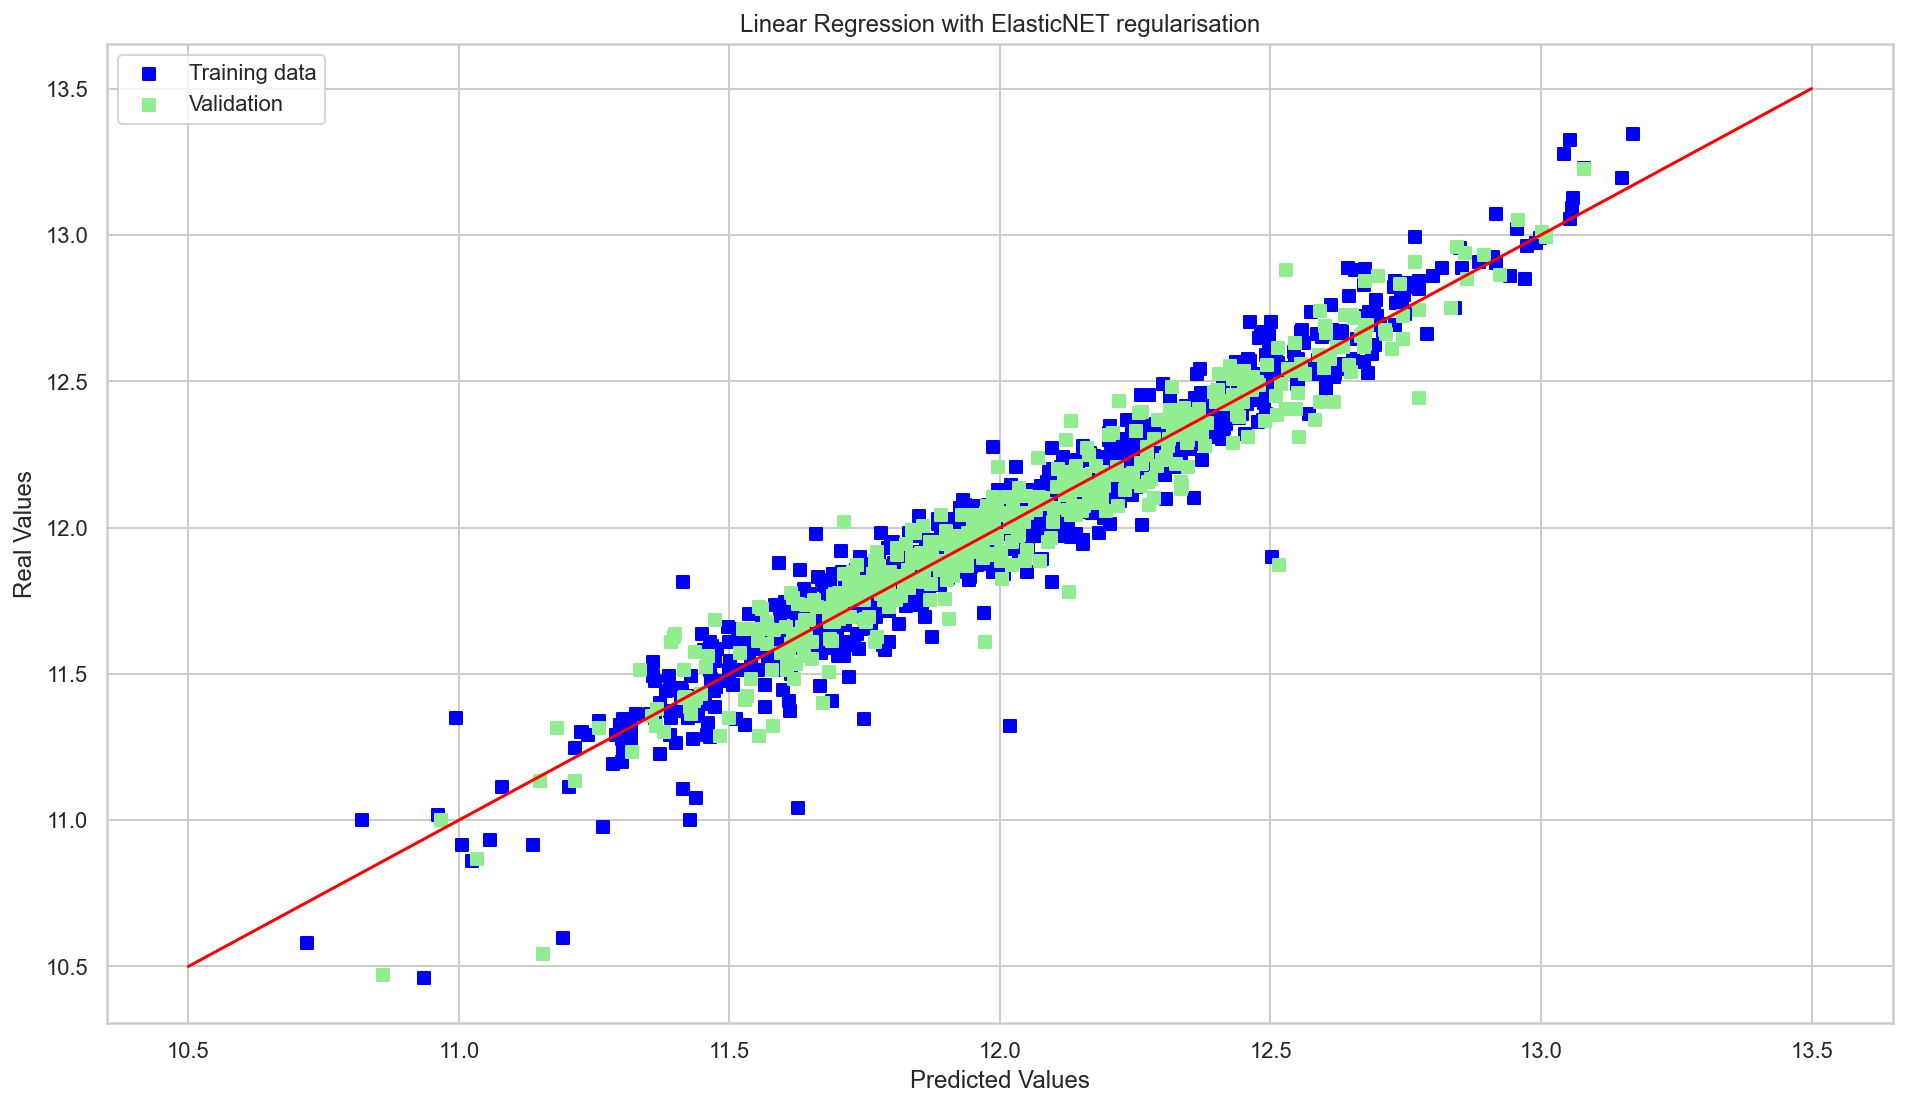

ElasticNET picked 104 features and eliminated the other 215 features


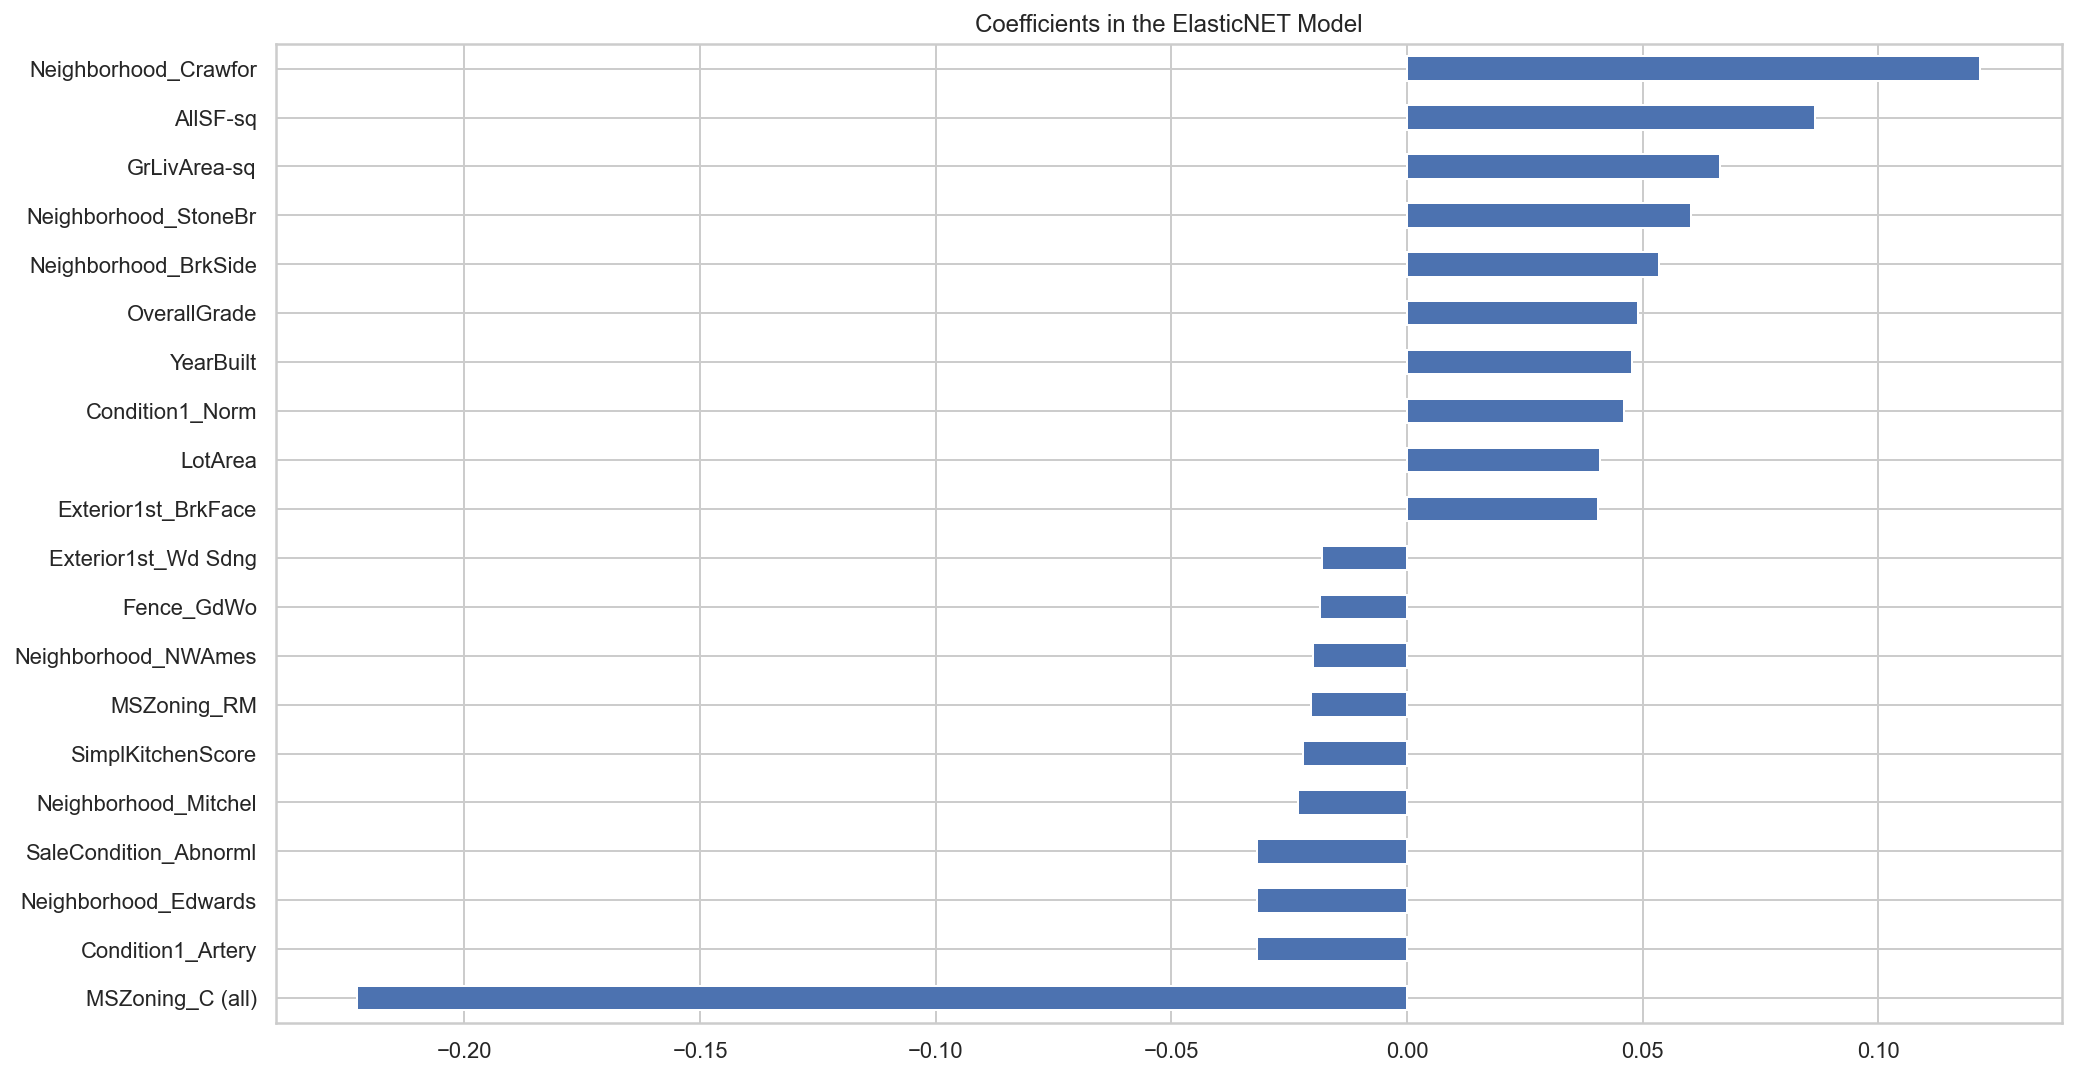

In [63]:
elastic_net_regression = ElasticNetCV(
    l1_ratio=[0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
    alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1],
    max_iter=50000,
    cv=10
)
elastic_net_regression.fit(X_train, y_train)
best_l1_ratio = elastic_net_regression.l1_ratio_
best_alpha = elastic_net_regression.alpha_
print(f"Best L1 Ratio {best_l1_ratio}")
print(f"Best alpha {best_alpha}")


print("Re-fit with alphas around the best alpha")
elastic_net_regression = ElasticNetCV(
    l1_ratio=[
        best_l1_ratio * .85,
        best_l1_ratio * .9,
        best_l1_ratio * .9,
        best_l1_ratio * .95,
        best_l1_ratio,
        best_l1_ratio * 1.05,
        best_l1_ratio * 1.1,
        best_l1_ratio * 1.15
    ],
    alphas=[
        best_alpha * .6,
        best_alpha * .65,
        best_alpha * .7,
        best_alpha * .75,
        best_alpha * .8,
        best_alpha * .85,
        best_alpha * .9,
        best_alpha * .9,
        best_alpha * .95,
        best_alpha,
        best_alpha * 1.05,
        best_alpha * 1.1,
        best_alpha * 1.15,
        best_alpha * 1.2,
        best_alpha * 1.25,
        best_alpha * 1.3,
        best_alpha * 1.35,
        best_alpha * 1.4,
    ],
    max_iter=50000,
    cv=10
)

elastic_net_regression.fit(X_train, y_train)

best_l1_ratio = elastic_net_regression.l1_ratio_
best_alpha = elastic_net_regression.alpha_
print(f"Best L1 Ratio {best_l1_ratio}")
print(f"Best alpha {best_alpha}")

print(f"ElasticNet RMSE on Training set: {rmse_cv_train(elastic_net_regression).mean()}")
print(f"ElasticNet RMSE on Test set: {rmse_cv_test(elastic_net_regression).mean()}")

y_train_pred = elastic_net_regression.predict(X_train)
y_test_pred = elastic_net_regression.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, 
            y_train_pred - y_train, 
            c="blue", 
            marker="s", 
            label="Training data")
plt.scatter(y_test_pred, 
            y_test_pred - y_test, 
            c="lightgreen", 
            marker="s", 
            label="Validation data")
plt.title("Linear Regression with ElasticNET regularisation")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, 
            y_train, 
            c="blue", 
            marker="s", 
            label="Training data")
plt.scatter(y_test_pred, 
            y_test, 
            c="lightgreen", 
            marker="s", 
            label="Validation")
plt.title("Linear Regression with ElasticNET regularisation")
plt.xlabel("Predicted Values")
plt.ylabel("Real Values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()


## Plot important coefficients
coefs = pd.Series(elastic_net_regression.coef_, index=X_train.columns)
print(f"ElasticNET picked {sum(coefs != 0)} features and eliminated the other {sum(coefs == 0)} features")
important_coefficients = pd.concat([coefs.sort_values().head(10),
                                   coefs.sort_values().tail(10)])
important_coefficients.plot(kind="barh")
plt.title("Coefficients in the ElasticNET Model")
plt.show()